<h2> Feature Engineering with tf</h2>

In [1]:
# import liberary
import tensorflow as tf
import apache_beam as beam    # for stream pipeline
import shutil
print(tf.__version__)

1.8.0


/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:33:03.602788. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h3> Running Environment Setup for Cloud ML</h3>

   - create unique project id on GCP storage
   - single region bucket for saving and restoring model files

In [2]:
# set up vm environment
import os
REGION = 'us-central1'    # region of cloud storage bucket
BUCKET = 'qwiklabs-gcp-0bb127b38c8a3a29'    # bucket name on the cloud ML engine
PROJECT = 'qwiklabs-gcp-0bb127b38c8a3a29'    # project name

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:33:12.533803. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
# bash environment
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:33:13.607775. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:33:14.602763. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h2> Pull Data from Big Query<h2>

In [5]:
# select features from BQ
def create_query(phase, EVERY_N):
  """
  Args: data use, train, validation, test
      phase: 1 = train, 
      phase: 2 = valid 
  Returnes: data table
  """
  
  # create bq query
  base_query = """
  SELECT 
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  -- create unique key from pickup info
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78    -- filter rides only within NYC
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
  
  # create train and valid data
  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      # Validation
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query
    
print(create_query(2, 100000))


  SELECT 
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  -- create unique key from pickup info
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78    -- filter rides only within NYC
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
   AND ABS(HASH(pickup_datetime)) % 100000 == 2


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:33:16.257556. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


</h2> Preprocessing Dataflow job from BigQuery</h2>
- use tf.transorm to preprocess and create data pipelie
- create CSV file using Dataflow

In [6]:
# run in from GCP
%bash
gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/

SyntaxError: invalid syntax (<ipython-input-6-8165c84c6121>, line 3)

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:33:19.829774. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [13]:
import datetime

# creare CSV
def to_csv(rowdict):
  import copy
  days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']   # null for no date
  CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
  result = copy.deepcopy(rowdict)
  result['dayofweek'] = days[result['dayofweek']]
  return ','.join([str(result[k]) for k in CSV_COLUMNS])

def preprocess_pipe(EVERy_N, RUNNER):
  job_name = 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  print('Launching Dataflow job {} ... hang on'.format(job_name))
  OUTDIR_DIR = 'gs://{0}/taxifare/ch4/taxi_preproc'.format(BUCKET)
  options = {
    'staging_location': os.path.join(OUTDIR_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTDIR_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flag=[], **options)
  p = beam.Pipeline(RUNNER, options=opts)
  for n, step in enumerate(['train', 'valid']):
    query = create_query(n+1, EVERy_N)
    outfile = os.path.join(OUTDIR_DIR, '{}.csv'.format(step))
    (
      p | 'read_{}'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=query))    # read file from BQ
        | 'tocsv{}'.format(step) >> beam.Map(to_csv)   # apply transformation
        | 'write{}'.format(step) >> beam.io.Write(beam.io.WriteToText(outfile))
    )
    
  p.run()

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:40:04.479735. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h4> Cloud vs. Local runs </h4>

In [14]:
preprocess_pipe(50*100000, 'DirectRunner')   # runs locally
# preprocess_pipe(50*100000, 'DataflowRunner') # runs on GCP

Launching Dataflow job preprocess-taxifeatures-180519-234320 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:43:20.989780. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
/usr/local/envs/py2env/lib/python2.7/site-packages/oauth2client/contrib/gce.py:99: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)
/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))


In [16]:
%bash
gsutil ls -l gsL//$BUCKET/taxifare/ch4/taxi_preproc/

CommandException: "ls" command does not support "file://" URLs. Did you mean to use a gs:// URL?
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:45:03.656789. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
%bash
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" | head

13.0,Wed,2,-73.991673,40.726478,-73.984347,40.766946,2.0,2013-06-05 02:48:26.000000-73.991740.726540.7669-73.9843
7.3,Sat,3,-74.008527,40.72596,-73.99455,40.751717,2.0,2010-01-30 03:00:00.000000-74.008540.72640.7517-73.9946
11.7,Sat,3,-73.98537,40.727553,-73.96169,40.77683,2.0,2010-01-30 03:00:00.000000-73.985440.727640.7768-73.9617
20.5,Sat,3,-73.98921,40.730808,-73.959545,40.808858,2.0,2010-01-30 03:00:00.000000-73.989240.730840.8089-73.9595
16.5,Sat,3,-73.982352,40.748493,-73.898938,40.74833,2.0,2010-01-30 03:00:00.000000-73.982440.748540.7483-73.8989
22.9,Sat,3,-74.00181,40.733712,-73.921113,40.815263,2.0,2010-01-30 03:00:00.000000-74.001840.733740.8153-73.9211
11.3,Sat,3,-73.92538,40.743755,-73.913053,40.705703,2.0,2010-01-30 03:00:00.000000-73.925440.743840.7057-73.9131
16.5,Sat,3,-73.990418,40.760835,-74.007462,40.707177,2.0,2010-01-30 03:00:00.000000-73.990440.760840.7072-74.0075
7.3,Sat,3,-73.97488,40.757017,-73.953557,40.78791,2.0,2010-01-30 03:00:00.000000-73.974940.75740.78

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:45:31.353806. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h2>Develop model with new inputs</h2>

- download a fraction of the preprocessed data to enable local dev
- the model in packaged in trainer folder

In [20]:
%bash 
# get data from cloud storage
mkdir sample
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" sample/train.csv
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/valid.csv-00000-of-*" sample/valid.csv

mkdir: cannot create directory ‘sample’: File exists
Copying gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_preproc/train.csv-00000-of-00001...
/ [1 files][ 53.4 KiB/ 53.4 KiB]                                                
Operation completed over 1 objects/53.4 KiB.                                     
Copying gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00001...
/ [1 files][  8.9 KiB/  8.9 KiB]                                                
Operation completed over 1 objects/8.9 KiB.                                      
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:49:57.767800. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
# new crossed columns are added in model.py
# see first 20 line on codes starting from "INPUT_COLUMNS
!grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

INPUT_COLUMNS = [
    # Define features
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']),
    tf.feature_column.categorical_column_with_identity('hourofday', num_buckets = 24),

    # Numeric columns
    tf.feature_column.numeric_column('pickuplon'),
    tf.feature_column.numeric_column('pickuplat'),
    tf.feature_column.numeric_column('dropofflat'),
    tf.feature_column.numeric_column('dropofflon'),
    tf.feature_column.numeric_column('passengers'),
    
    # Engineered features that are created in the input_fn
    tf.feature_column.numeric_column('latdiff'),
    tf.feature_column.numeric_column('londiff'),
    tf.feature_column.numeric_column('euclidean')
]

# Build the estimator
def build_estimator(model_dir, nbuckets, hidden_units):
    """


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:57:49.015803. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
# check build estimator model
!grep -A 50 "build_estimator" taxifare/trainer/model.py

def build_estimator(model_dir, nbuckets, hidden_units):
    """
     Build an estimator starting from INPUT COLUMNS.
     These include feature transformations and synthetic features.
     The model is a wide-and-deep model.
  """

    # Input columns
    (dayofweek, hourofday, plon, plat, dlon, dlat, pcount, latdiff, londiff, euclidean) = INPUT_COLUMNS

    # Bucketize the lats & lons
    latbuckets = np.linspace(38.0, 42.0, nbuckets).tolist()
    lonbuckets = np.linspace(-76.0, -72.0, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(plat, latbuckets)
    b_dlat = tf.feature_column.bucketized_column(dlat, latbuckets)
    b_plon = tf.feature_column.bucketized_column(plon, lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(dlon, lonbuckets)

    # Feature cross
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.cr

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:58:27.902795. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [25]:
# check added features
!grep -A 15 "add_engineered(" taxifare/trainer/model.py

def add_engineered(features):
    # this is how you can do feature engineering in TensorFlow
    lat1 = features['pickuplat']
    lat2 = features['dropofflat']
    lon1 = features['pickuplon']
    lon2 = features['dropofflon']
    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    
    # set features for distance with sign that indicates direction
    features['latdiff'] = latdiff
    features['londiff'] = londiff
    dist = tf.sqrt(latdiff * latdiff + londiff * londiff)
    features['euclidean'] = dist
    return features

--
    return tf.estimator.export.ServingInputReceiver(add_engineered(features), feature_placeholders)

# Create input function to load data into datasets
def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return 

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-19 23:59:09.665812. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h3> Run the new model </h3>

In [26]:
%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/taxifare
  python -m trainer.task \
    --train_data_paths="${PWD}/sample/train" \
    --eval_data_paths=${PWD}/sample/valid.csv \
    --output_dir=${PWD}/taxi_trained \
    --train_steps=1000 \
    --job-dir=/tmp

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f05ddb55a10>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/content/datalab/training-data-analyst/courses/machine_learning/feateng/taxi_trained/', '_global_id

In [27]:
!ls taxi_trained/export/exporter/

1526774631


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:04:21.566783. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [28]:
%writefile /tmp/test.json
{"dayofweek": "Sun", "hourofday": 17, "pickuplon": -73.885262, "pickuplat": 40.773008, "dropofflon": -73.987232, "dropofflat": 40.732403, "passengers": 2}

Writing /tmp/test.json


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:04:56.185803. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [29]:
%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter)
gcloud ml-engine local predict \
  --model-dir=${PWD}/taxi_trained/export/exporter/${model_dir} \
  --json-instances=/tmp/test.json

PREDICTIONS
[-15.447600364685059]


  from ._conv import register_converters as _register_converters

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:07:05.970774. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h2>Train on Cloud</h2>

In [31]:
!gcloud --quiet components update



Your current Cloud SDK version is: 200.0.0
You will be upgraded to version: 201.0.0

┌─────────────────────────────────────────────────┐
│        These components will be updated.        │
├──────────────────────────┬────────────┬─────────┤
│           Name           │  Version   │   Size  │
├──────────────────────────┼────────────┼─────────┤
│ Cloud SDK Core Libraries │ 2018.05.11 │ 8.0 MiB │
│ gcloud cli dependencies  │ 2018.05.11 │ 1.6 MiB │
└──────────────────────────┴────────────┴─────────┘

The following release notes are new in this upgrade.
Please read carefully for information about new features, breaking changes,
and bugs fixed.  The latest full release notes can be viewed at:
  https://cloud.google.com/sdk/release_notes

201.0.0 (2018-05-15)
  Breaking Changes
      ▪ **(Compute Engine)** Modified default TPU accelerator type to v2-8
        for gcloud compute tpus commands. tpu-v2 has been deprecated.

  Cloud Bigtable
      ▪ Added the following commands to the gcloud be

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:10:09.516792. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [32]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=${PWD}/taxifare/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=BASIC \
  --runtime-version=1.4 \
  -- \
  --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
  --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
  --train_steps=5000 \
  --output_dir=$OUTDIR

gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_trained us-central1 lab4a_180520_001104
jobId: lab4a_180520_001104
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [lab4a_180520_001104] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe lab4a_180520_001104

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs lab4a_180520_001104
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:11:04.126558. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h2> 6. Hyper-parameter tune </h2>

<ol>
<li> train_batch_size: 512 </li>
<li> nbuckets: 16 </li>
<li> hidden_units: "64 64 64 8" </li>    
</ol>

<h1> Run Cloud training on 2 million row dataset </h1>

This run uses as input 2 million rows and takes ~20 minutes with 10 workers (STANDARD_1 pricing tier). The model is exactly the same as above. The only changes are to the input (to use the larger dataset) and to the Cloud MLE tier (to use STANDARD_1 instead of BASIC -- STANDARD_1 is approximately 10x more powerful than BASIC). Because the Dataflow preprocessing takes about 15 minutes, we train here using CSV files in a public bucket.

When doing distributed training, use train_steps instead of num_epochs. The distributed workers don't know how many rows there are, but we can calculate train_steps = num_rows \* num_epochs / train_batch_size. In this case, we have 2141023 * 100 / 512 = 418168 train steps.

In [33]:
%%bash

WARNING -- this uses significant resources and is optional. Remove this line to run the block.

OUTDIR=gs://${BUCKET}/taxifare/feateng2m
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=1.4 \
   -- \
   --train_data_paths="gs://cloud-training-demos/taxifare/train*" \
   --eval_data_paths="gs://cloud-training-demos/taxifare/valid*"  \
   --output_dir=$OUTDIR \
   --train_steps=418168 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/feateng2m us-central1 lab4a_180520_001236
jobId: lab4a_180520_001236
state: QUEUED


bash: line 2: WARNING: command not found
CommandException: 1 files/objects could not be removed.
Job [lab4a_180520_001236] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe lab4a_180520_001236

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs lab4a_180520_001236
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:12:35.997799. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [34]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/feateng2m'.format(BUCKET)
print OUTDIR
TensorBoard().start(OUTDIR)

/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .pairwise_fast import _chi2_kernel_fast, _sparse_manhattan


gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/feateng2m


TensorBoard was started successfully with pid 7006. Click here to access it.

7006

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:12:46.336814. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:338: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


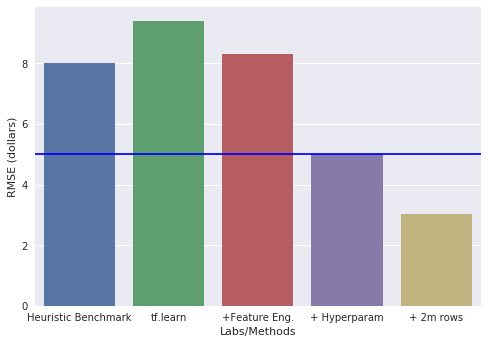

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:286: DeprecationWarning: Interpreting naive datetime as local 2018-05-20 00:13:22.087814. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 2m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data = df, x = 'Method', y = 'RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20, 120, 1000), [5] * 1000, 'b');

In [36]:
%bash
gsutil -m mv gs://${BUCKET}/taxifare/ch4/  gs://${BUCKET}/taxifare/ch4_1m/

Copying gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_preproc/train.csv-00000-of-00001 [Content-Type=text/plain]...
Copying gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00001 [Content-Type=text/plain]...
Copying gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_trained/eval/events.out.tfevents.1526775153.cmle-training-9020182672160085571...
Copying gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_trained/checkpoint...
Copying gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_trained/events.out.tfevents.1526775142.cmle-training-9020182672160085571...
Removing gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_preproc/train.csv-00000-of-00001...
Removing gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_trained/eval/events.out.tfevents.1526775153.cmle-training-9020182672160085571...
Removing gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00001...
Removing gs://qwiklabs-gcp-0bb127b38c8a3a29/taxifare/